In [81]:
import numpy as np
import math
import pandas as pd

from numba import jit, prange

import timeit
from timeit import default_timer as timer
import dask

In [3]:
%matplotlib inline

In [4]:
def assetPathsCPU(S0,mu,sigma,T,nRows,nPaths):
    dt = T/nRows
    nudt = (mu-0.5*sigma**2)*dt    
    sidt = sigma*math.sqrt(dt)
    increments = nudt + sidt*np.random.randn(int(nRows),int(nPaths))
    x=np.concatenate((math.log(S0)*np.ones((1,int(nPaths))),increments))
    pricePaths=np.exp(np.cumsum(x,axis=0))

    return pricePaths


In [5]:
%%timeit

nRows=252*10
nPaths=10000
# define parameters
S0 = 100.0
T = 10.0
mu = 0.1
sigma = 0.1
# simulate price paths
assetPathsCPU(S0,mu,sigma,T,nRows,nPaths)


1.27 s ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# define simulation parameters
nRows=252*10
nPaths=1000
# define parameters
S0 = 100.0
T = 10.0
mu = 0.1
sigma = 0.1
# simulate price paths
pricePathsCPU=assetPathsCPU(S0,mu,sigma,T,nRows,nPaths)


In [7]:
df=pd.DataFrame(pricePathsCPU)

Classical momentum computes growth 

In [8]:
x=np.arange(0,10)


In [9]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
x[0]


0

In [11]:
x[-1]


9

In [12]:
def linregressCPU(x, y):

    TINY = 1.0e-20

    x = np.asarray(x)
    y = np.asarray(y)

    n = len(x)
    xmean = np.mean(x)
    ymean = np.mean(y)

    # average sum of squares:
    ssxm, ssxym, ssyxm, ssym = np.cov(x, y, bias=1).flat
    r_num = ssxym
    r_den = np.sqrt(ssxm * ssym)
    if r_den == 0.0:
        r = 0.0
    else:
        r = r_num / r_den
        # test for numerical error propagation
        if r > 1.0:
            r = 1.0
        elif r < -1.0:
            r = -1.0

    df = n - 2
    slope = r_num / ssxm
    intercept = ymean - slope*xmean
    if n == 2:
        sterrest = 0.0
    else:
        t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
        sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)

    return (slope, intercept, r, sterrest)


In [55]:
@jit(nopython=True)
def linregressNumba(x, y):

    TINY = 1.0e-20

    x = np.asarray(x)
    y = np.asarray(y)

    n = len(x)
    xmean = np.mean(x)
    ymean = np.mean(y)

    # average sum of squares:
    ssxm, ssxym, ssyxm, ssym = np.cov(x, y, bias=1).flat
    r_num = ssxym
    r_den = np.sqrt(ssxm * ssym)
    if r_den == 0.0:
        r = 0.0
    else:
        r = r_num / r_den
        # test for numerical error propagation
        if r > 1.0:
            r = 1.0
        elif r < -1.0:
            r = -1.0

    df = n - 2
    slope = r_num / ssxm
    intercept = ymean - slope*xmean
    if n == 2:
        sterrest = 0.0
    else:
        t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
        sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)

    return (slope, intercept, r, sterrest)


In [13]:
# compute classical price momentum
def price2ClassicalMomentum(y):    
    return ((1+((np.log(y[-1])-np.log(y[0]))/len(y)))**252.0)-1

In [14]:
@jit(nopython=True)
# compute classical price momentum
def price2ClassicalMomentumNumba(y):    
    return ((1+((np.log(y[-1])-np.log(y[0]))/len(y)))**252.0)-1


In [15]:
# compute price momentum
def price2momentum(y):
    x=np.arange(0,len(y))
    slope, intercept, r_value, sterrest = linregressCPU(x,
        np.log(y))
    # adjust the momentum for smoothness and annualize
    momentum=(((1+slope)**252.0)-1)*(r_value**2.0)
    return momentum


In [56]:
@jit(nopython=True)
# compute price momentum
def price2momentumNumba(y):
    x=np.arange(0,len(y))
    slope, intercept, r_value, sterrest = linregressNumba(x,
        np.log(y))
    # adjust the momentum for smoothness and annualize
    momentum=(((1+slope)**252.0)-1)*(r_value**2.0)
    return momentum


In [69]:
# classical momentum
def classicalMomentumPathsNumpy(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    momentumPaths=np.zeros([T,nPaths])
    # iterate over each price path
    for pathIndex in range(0,nPaths):
        # iterate over each point in time and compute the EMA 
        for t in range(1,T):
            if t>=lookback:
                momentumPaths[t,pathIndex]=((1+((np.log(pricePaths[t,
                    pathIndex])-np.log(pricePaths[t-lookback,
                    pathIndex]))/lookback))**252)-1

    return momentumPaths


In [70]:
@jit(nopython=True)
# classical momentum
def classicalMomentumPathsNumba(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    momentumPaths=np.zeros_like(pricePaths)
    # iterate over each price path
    for pathIndex in range(0,nPaths):
        # iterate over each point in time and compute the EMA 
        for t in range(1,T):
            if t>=lookback:
                momentumPaths[t,pathIndex]=((1+((np.log(pricePaths[t,
                    pathIndex])-np.log(pricePaths[t-lookback,
                    pathIndex]))/lookback))**252)-1

    return momentumPaths


In [195]:
@jit(nopython=True, parallel=True)
# classical momentum
def classicalMomentumPathsNumbaParallel(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    momentumPaths=np.zeros_like(pricePaths)
    # iterate over each price path
    for pathIndex in prange(0,nPaths):
        # iterate over each point in time and compute the EMA 
        for t in prange(1,T):
            if t>=lookback:
                momentumPaths[t,pathIndex]=((1+((np.log(pricePaths[t,
                    pathIndex])-np.log(pricePaths[t-lookback,
                    pathIndex]))/lookback))**252)-1

    return momentumPaths


In [85]:
def emaPathsNumpy(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    ema=np.zeros([T,nPaths])
    # compute smoothing constant
    a = 2.0 / ( lookback + 1.0 )
    # iterate over each price path
    for pathIndex in range(0,nPaths):
        # iterate over each price path
        ema[0,pathIndex] = pricePaths[0,pathIndex]
        # iterate over each point in time and compute the EMA 
        for t in range(1,T):
            ema[t,pathIndex]=a * (pricePaths[t,pathIndex]-ema[t-1,
                pathIndex]) + ema[t-1,pathIndex]
    return ema


In [86]:
@jit(nopython=True)
def emaPathsNumba(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    #ema=np.zeros([T,nPaths])
    ema=np.zeros_like(pricePaths)
    # compute smoothing constant
    a = 2.0 / ( lookback + 1.0 )
    # iterate over each price path
    for pathIndex in range(0,nPaths):
        # iterate over each price path
        ema[0,pathIndex] = pricePaths[0,pathIndex]
        # iterate over each point in time and compute the EMA 
        for t in range(1,T):
            ema[t,pathIndex]=a * (pricePaths[t,pathIndex]-ema[t-1,
                pathIndex]) + ema[t-1,pathIndex]

    return ema


In [87]:
@jit(nopython=True, parallel=True)
def emaPathsNumbaParallel(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    #ema=np.zeros([T,nPaths])
    ema=np.zeros_like(pricePaths)
    # compute smoothing constant
    a = 2.0 / ( lookback + 1.0 )
    # iterate over each price path
    for pathIndex in prange(0,nPaths):
        # iterate over each price path
        ema[0,pathIndex] = pricePaths[0,pathIndex]
        # iterate over each point in time and compute the EMA 
        for t in prange(1,T):
            ema[t,pathIndex]=a * (pricePaths[t,pathIndex]-ema[t-1,
                pathIndex]) + ema[t-1,pathIndex]

    return ema


In [99]:
def priceMomentum2UniverseRelativeRankNumpy(momentum,nPositions):
    # find T and number of instruments
    T,nInstruments=momentum.shape

    # create data frames to store results
    momentumRank=np.zeros_like(momentum)
    momentumFlag=np.zeros_like(momentum)
    # iterate over each instant in time, t
    for t in range(0,T):
        # find sort index for momentum of each instrument in universe
        momentumIndex=np.argsort(momentum[t,:]*-1,axis=0)
        # based on sorted momentum, determine relative rank
        momentumRank[t,momentumIndex]=np.arange(1,nInstruments+1)
        # If the rank is less than target number of positions, then condition 
        # is met (i.e., stock is considered to have 'momentum') over defined 
        # lookback period
        momentumFlag=momentumRank[t,:]<=nPositions
    
    return momentumRank,momentumFlag


In [ ]:
indexTable = np.empty_like(finaltable)
for j in range(indexTable.shape[1]):
    indexTable[:, j] = np.argsort(finaltable[:, j])

In [187]:
@jit(nopython=True)
def priceMomentum2UniverseRelativeRankNumba(momentum,nPositions):
    # find T and number of instruments
    T,nInstruments=momentum.shape

    # create data frames to store results
    #momentumRank=np.empty_like(momentum,'int')
    momentumRank=np.empty_like(momentum)
    momentumFlag=np.zeros_like(momentum)
    # iterate over each instant in time, t
    for t in range(0,T):
        # find sort index for momentum of each instrument in universe
        momentumIndex=np.argsort(momentum[t,:]*-1.0)
        # based on sorted momentum, determine relative rank
        momentumRank[t,momentumIndex]=np.arange(nInstruments)+1.0
        # If the rank is less than target number of positions, then condition 
        # is met (i.e., stock is considered to have 'momentum') over defined 
        # lookback period
        #momentumFlag=momentumRank[t,:]<=nPositions
    
    return momentumRank #,momentumFlag


In [106]:
@jit(nopython=True, parallel=True)
def priceMomentum2UniverseRelativeRankNumbaParallel(momentum,nPositions):
    # find T and number of instruments
    T,nInstruments=momentum.shape
    # create array to store results
    momentumRank=np.zeros_like(momentum)
    momentumFlag=np.zeros_like(momentum)
    # iterate over each instant in time, t
    for t in prange(0,T):
        # find sort index for momentum of each instrument in universe
        momentumIndex=np.argsort(momentum[t,:]*-1,axis=0)
        # based on sorted momentum, determine relative rank
        momentumRank[t,momentumIndex]=np.arange(nInstruments)+1
        # If the rank is less than target number of positions, then condition 
        # is met (i.e., stock is considered to have 'momentum') over defined 
        # lookback period
        momentumFlag=momentumRank[t,:]<=nPositions
    
    return momentumRank,momentumFlag


In [65]:
# apply price gap filter
def priceGapFilter(y):
    # set gap filter
    threshold=0.15
    # find gap flag
    gapFlag=np.max(np.abs(np.diff(np.log(y))))>=threshold

    return gapFlag


In [66]:
@jit(nopython=True)
# apply price gap filter
def priceGapFilterNumba(y):
    # set gap filter
    threshold=0.15
    # find gap flag
    gapFlag=np.max(np.abs(np.diff(np.log(y))))>=threshold

    return gapFlag


In [17]:
hpr=1.1**(1.0/252.0)
#y=np.ones(252)*growth
hpr

1.0003782865315343

In [18]:
hpr**252.0

1.1000000000000063

In [19]:
np.log(hpr)

0.0003782149992235343

In [20]:
y=np.exp(np.cumsum(np.ones(2520)*np.log(hpr)))

In [21]:
yy=y[0:90]

In [22]:
len(yy)

90

In [23]:
((1+((np.log(yy[-1])-np.log(yy[0]))/len(yy)))**252.0)-1

0.09881635180021897

In [24]:
x=np.arange(0,len(yy))
slope, intercept, r_value, sterrest = linregressCPU(x,np.log(yy))
# adjust the momentum for smoothness and annualize
momentum=(((1+slope)**252.0)-1)*(r_value**2.0)

In [25]:
r_value

1.0

In [26]:
momentum

0.09998017891945699

In [27]:
trendDf=pd.DataFrame(y)

In [28]:
trendDf.tail()

,0
2515,2.589821
2516,2.590801
2517,2.591781
2518,2.592762
2519,2.593742


In [29]:
%%timeit
momentumLookback=90
# compute momentum
df.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)


14.1 s ± 91.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
momentumLookback=90
# compute momentum
df.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentumNumba,
    raw=True)


1.43 s ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
%%timeit
momentumLookback=90
classicalMomentumPathsNumpy(df.values,momentumLookback)

14 s ± 71.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [75]:
%%timeit
momentumLookback=90
classicalMomentumPathsNumba(df.values,momentumLookback)

139 ms ± 890 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
%%timeit 
momentumLookback=90
classicalMomentumPathsNumbaParallel(df.values,momentumLookback)

18 ms ± 298 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%%timeit
momentumLookback=90
# compute momentum
df.rolling(center=False,window=momentumLookback).apply(func=price2momentum,
    raw=True)

2min 59s ± 675 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
%%timeit
momentumLookback=90
# compute momentum
df.rolling(center=False,window=momentumLookback).apply(func=price2momentumNumba,
    raw=True)

11.4 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
momentumLookback=90
# compute momentum
momentumDf=df.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)

In [67]:
%%timeit
gapLookback=90
# build gap flag
gapDf=df.rolling(center=False,window=gapLookback).apply(func=priceGapFilter,
    raw=True)

29.6 s ± 73.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%%timeit
gapLookback=90
# build gap flag
gapDf=df.rolling(center=False,window=gapLookback).apply(func=priceGapFilterNumba,
    raw=True)

6.62 s ± 49.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
%%timeit 
momentumLookback=90
nPositions=100
momentum=classicalMomentumPathsNumbaParallel(df.values,momentumLookback)
relativeRankNumpy,momentumFlagNumpy=priceMomentum2UniverseRelativeRankNumpy(momentum,nPositions)

166 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [183]:
momentumLookback=90
nPositions=100

momentum=classicalMomentumPathsNumbaParallel(df.values,momentumLookback)

# find T and number of instruments
T,nInstruments=momentum.shape

# create data frames to store results
#momentumRank=np.empty_like(momentum,'int')
momentumRank=np.empty_like(momentum)
momentumFlag=np.zeros_like(momentum)
# iterate over each instant in time, t
for t in range(0,T):
    # find sort index for momentum of each instrument in universe
    momentumIndex=np.argsort(momentum[t,:]*-1.0)
    # based on sorted momentum, determine relative rank
    momentumRank[t,momentumIndex]=np.arange(nInstruments)+1
    # If the rank is less than target number of positions, then condition 
    # is met (i.e., stock is considered to have 'momentum') over defined 
    # lookback period
    momentumFlag=momentumRank[t,:]<=nPositions


In [178]:
momentumRank=np.empty_like(momentum,'int')

In [158]:
rankTest=np.arange(nInstruments)

In [169]:
np.argmax(momentum[-1,:])

468

In [184]:
momentumRank[-1,468]

1.0

In [185]:
np.argmin(momentum[-1,:])

894

In [186]:
momentumRank[-1,894]

1000.0

In [171]:
momentumRank[-1,0]

993

In [174]:
momentumIndex

array([468, 366, 901, 373, 645, 167, 444, 922, 306, 208,  28,   6, 804,
       578, 177, 154, 594, 802,  52, 328, 530, 431, 517, 779, 297, 283,
       984, 462, 695, 606, 508, 795, 326, 102, 762, 433, 631, 227, 758,
       874, 791, 905, 146, 775, 891, 376, 563, 138, 945, 488, 228,  67,
       733, 781, 607, 185, 353, 875,  76, 526, 141, 959, 116, 915, 769,
       860, 510, 499, 575, 999,  21, 929, 629, 377, 664, 665, 187, 384,
       401, 962, 239,  62, 347, 814,   5, 898, 659,  72, 398, 108, 658,
       191, 912, 675, 375,  58, 485, 936,  11, 862, 699, 990, 673, 224,
       350, 307, 649,  38, 696, 763,  80, 813, 833, 786, 741,  97,  71,
       597, 250, 709, 690, 842, 963,   4, 480, 533, 262, 255, 368, 361,
       450, 193, 783, 540, 466,  35, 213, 439, 417,  33, 529, 428, 487,
       494, 932, 144, 261, 104, 993, 195,  34, 276, 470, 608, 803, 941,
       279, 452, 225, 558, 593, 515, 837, 829, 236, 523, 423, 525, 639,
       247, 917, 761, 816, 356, 856, 222, 395, 995, 388, 415, 99

In [164]:
momentum[-1,:]

array([-2.63942751e-01,  2.74635250e-01,  1.56465205e-02,  2.10463772e-01,
        3.30731341e-01,  3.90837430e-01,  6.02022637e-01, -3.51923054e-02,
        2.25692793e-01,  2.72510532e-02,  1.52648589e-01,  3.71813967e-01,
        1.68217661e-01,  2.44085187e-01, -1.48732770e-01, -4.50620839e-02,
        6.73232800e-03,  2.26849451e-02,  6.50116141e-03,  2.87731389e-03,
       -1.35955684e-01,  4.03343993e-01, -1.31178100e-02, -2.48461372e-02,
        6.23257802e-02, -6.13288925e-03,  3.00537765e-02,  1.08598049e-01,
        6.09766288e-01,  1.74670890e-01,  9.47912843e-02, -1.27932267e-01,
        2.41771775e-01,  3.15356486e-01,  3.04637593e-01,  3.18830866e-01,
       -1.41140136e-02,  8.06660054e-02,  3.56941349e-01,  1.85616644e-01,
        9.58287201e-02,  2.16371188e-01,  2.64793282e-02, -7.38968705e-02,
        1.27829490e-01,  1.16536725e-01,  2.30116876e-01,  6.25429766e-02,
        1.84839769e-01,  1.04876773e-01,  2.01084690e-02,  1.82987885e-01,
        5.44504654e-01,  

In [155]:
momentumRank[-1,momentumIndex[0:10]]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [154]:
momentumIndex[0:10]

array([468, 366, 901, 373, 645, 167, 444, 922, 306, 208])

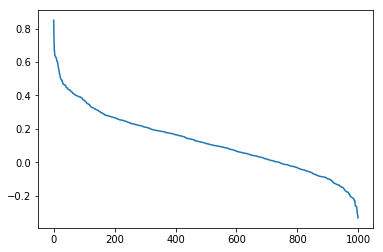

In [142]:
pd.DataFrame(momentum[-1,momentumIndex]).plot(legend=False)

In [116]:
momentum[-1,:]

array([-2.63942751e-01,  2.74635250e-01,  1.56465205e-02,  2.10463772e-01,
        3.30731341e-01,  3.90837430e-01,  6.02022637e-01, -3.51923054e-02,
        2.25692793e-01,  2.72510532e-02,  1.52648589e-01,  3.71813967e-01,
        1.68217661e-01,  2.44085187e-01, -1.48732770e-01, -4.50620839e-02,
        6.73232800e-03,  2.26849451e-02,  6.50116141e-03,  2.87731389e-03,
       -1.35955684e-01,  4.03343993e-01, -1.31178100e-02, -2.48461372e-02,
        6.23257802e-02, -6.13288925e-03,  3.00537765e-02,  1.08598049e-01,
        6.09766288e-01,  1.74670890e-01,  9.47912843e-02, -1.27932267e-01,
        2.41771775e-01,  3.15356486e-01,  3.04637593e-01,  3.18830866e-01,
       -1.41140136e-02,  8.06660054e-02,  3.56941349e-01,  1.85616644e-01,
        9.58287201e-02,  2.16371188e-01,  2.64793282e-02, -7.38968705e-02,
        1.27829490e-01,  1.16536725e-01,  2.30116876e-01,  6.25429766e-02,
        1.84839769e-01,  1.04876773e-01,  2.01084690e-02,  1.82987885e-01,
        5.44504654e-01,  

In [115]:
momentumRank[-1,:]

array([ 993.,  184.,  704.,  299.,  124.,   85.,   12.,  803.,  268.,
        685.,  427.,   99.,  394.,  239.,  946.,  817.,  723.,  692.,
        724.,  729.,  935.,   71.,  758.,  784.,  608.,  746.,  680.,
        510.,   11.,  379.,  544.,  924.,  242.,  140.,  151.,  136.,
        761.,  575.,  108.,  352.,  539.,  292.,  687.,  861.,  467.,
        494.,  259.,  607.,  354.,  516.,  696.,  360.,   19.,  206.,
        222.,  262.,  236.,  324.,   96.,  925.,  961.,  875.,   82.,
        513.,  775.,  286.,  464.,   52.,  990.,  441.,  804.,  117.,
         88.,  874.,  225.,  405.,   59.,  971.,  649.,  585.,  111.,
        571.,  936.,  774.,  679.,  355.,  824.,  339.,  188.,  683.,
        375.,  969.,  675.,  601.,  278.,  439.,  741.,  116.,  825.,
        498.,  827.,  555.,   34.,  346.,  148.,  577.,  213.,  186.,
         90.,  789.,  340.,  655.,  418.,  686.,  624.,  752.,   63.,
        849.,  483.,  926.,  295.,  313.,  765.,  706.,  986.,  486.,
        434.,  567.,

In [188]:
%%timeit 
momentumLookback=90
nPositions=100
momentum=classicalMomentumPathsNumbaParallel(df.values,momentumLookback)
#relativeRankNumba,momentumFlagNumba=priceMomentum2UniverseRelativeRankNumba(momentum,nPositions)

relativeRankNumba=priceMomentum2UniverseRelativeRankNumba(momentum,nPositions)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<built-in function setitem>) with argument(s) of type(s): (array(float64, 2d, C), (int64, array(int64, 1d, C)), array(float64, 1d, C))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates rejected without literals.
In definition 6:
    All templates rejected with literals.
In definition 7:
    All templates rejected without literals.
In definition 8:
    NotImplementedError: only one advanced index supported
    raised from /opt/conda/lib/python3.6/site-packages/numba/typing/arraydecl.py:67
In definition 9:
    NotImplementedError: only one advanced index supported
    raised from /opt/conda/lib/python3.6/site-packages/numba/typing/arraydecl.py:67
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: typing of setitem at <ipython-input-187-47780d157ff2> (15)

File "<ipython-input-187-47780d157ff2>", line 15:
def priceMomentum2UniverseRelativeRankNumba(momentum,nPositions):
    <source elided>
        # based on sorted momentum, determine relative rank
        momentumRank[t,momentumIndex]=np.arange(nInstruments)+1.0
        ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [ ]:
%%timeit 
momentumLookback=90
nPositions=100
momentum=classicalMomentumPathsNumbaParallel(df.values,momentumLookback)
relativeRank,momentumFlag=priceMomentum2UniverseRelativeRankNumbaParallel(momentum,nPositions)

In [192]:
%%timeit
emaLookback=200
df.ewm(span=emaLookback,min_periods=0,ignore_na=True).mean()

249 ms ± 2.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [88]:
%%timeit 
emaLookback=200
emaPathsNumpy(df.values,emaLookback)


3.78 s ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
%%timeit 
emaLookback=200
emaPathsNumba(df.values,emaLookback)


22.5 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
%%timeit 
emaLookback=200
emaPathsNumbaParallel(df.values,emaLookback)


6.27 ms ± 606 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [222]:
emaLookback=200
ema_1=df.ewm(span=emaLookback,min_periods=emaLookback,ignore_na=True).mean()
ema_3=emaPathsNumpy(df.values,emaLookback)
ema_2=emaPathsNumbaParallel(df.values,emaLookback)
np.all(ema_3==ema_2)

True

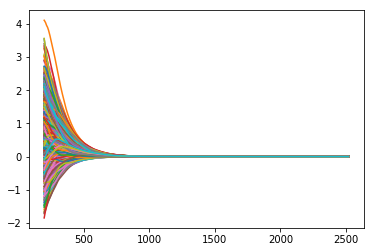

In [223]:
pd.DataFrame(ema_1.values-ema_2).dropna().plot(legend=False)

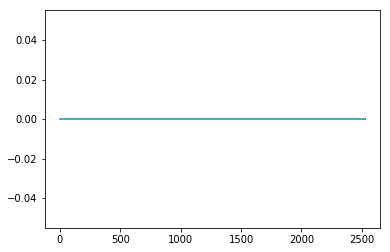

In [221]:
pd.DataFrame(ema_3-ema_2).dropna().plot(legend=False)

In [34]:
%%timeit
momentumLookback=90
# compute momentum
trendDf.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)

14.7 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
momentumLookback=90



In [35]:
#
momentumLookback=90
#
trendMomentum=trendDf.rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)

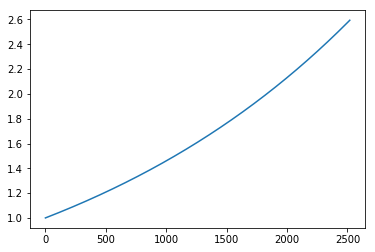

In [36]:
trendDf.plot(legend=False)

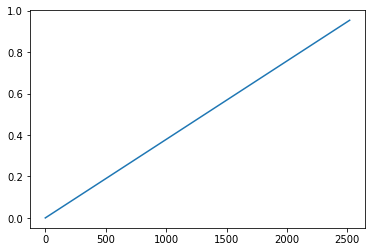

In [37]:
trendDf.apply(lambda x: np.log(x)).plot(legend=False)

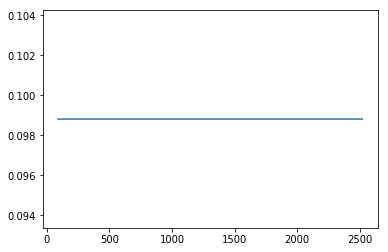

In [38]:
trendMomentum.plot(legend=False)

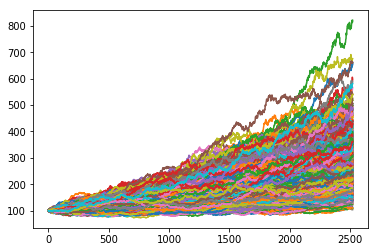

In [39]:
df.plot(legend=False)

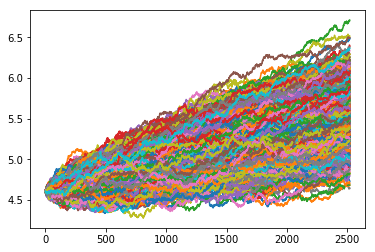

In [40]:
df.apply(lambda x : np.log(x)).plot(legend=False)

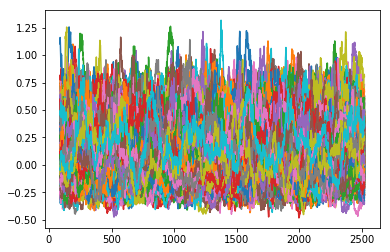

In [41]:
momentumDf.plot(legend=False)

In [42]:
momentumPercentileDf=momentumDf.quantile([.1, .5,.9],axis=1).T

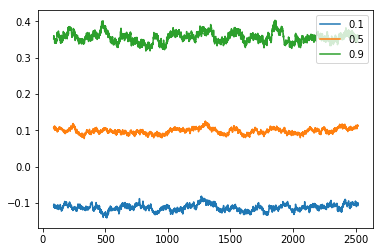

In [43]:
momentumPercentileDf.plot()

In [44]:
momentumPercentileDf.mean()

0.1   -0.112104
0.5    0.098134
0.9    0.355496
dtype: float64

In [45]:
percentileDf=df.quantile([.1, .5,.9],axis=1).T

In [46]:
((percentileDf[0.5].values[90]/percentileDf[0.5].values[0])**(252/momentumLookback))-1

0.10604712107505132

In [47]:
((1+((np.log(percentileDf[0.5].values[90])-np.log(percentileDf[0.5].values[0]))/momentumLookback))**252.0)-1

0.10602483264753992

In [48]:
medianMomentum=percentileDf[0.5].rolling(center=False,window=momentumLookback).apply(func=price2ClassicalMomentum,
    raw=True)

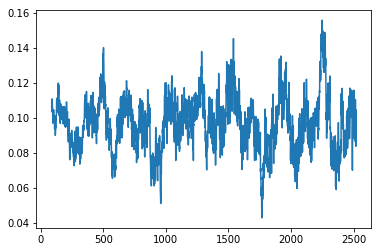

In [49]:
medianMomentum.plot(legend=False)

In [242]:
#import dask.dataframe as dd

In [243]:
#%%timeit
#nPartitions=252*10
#momentumLookback=90
#dA = dd.from_pandas(df, npartitions=nPartitions)
#dA.rolling(window=momentumLookback, center=False).apply(func=price2ClassicalMomentum2,
#    raw=True).compute()


In [244]:
#nPartitions=90
#momentumLookback=90
#dA = dd.from_pandas(df, npartitions=nPartitions)
#priceMomentum=dA.rolling(window=momentumLookback, center=False).apply(func=price2ClassicalMomentum2,
#    raw=True)

In [245]:
#priceMomentum.to_pandas.plot()